In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
# import lightgbm as lgb
from pandas_summary import DataFrameSummary
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50
from pathlib import Path
from fastai.structured import *

C:\Users\NokChan\Anaconda3\envs\fastai\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch

## Pre-Processing

In [3]:
path = Path('.')

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('load train...')
train_df = pd.read_csv("train_sample.csv.zip", nrows=80000, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
print('load test...')
test_df = pd.read_csv("test.csv.zip", nrows=1000, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

load train...
load test...


In [4]:
train_df.click_time = pd.to_datetime(train_df.click_time)
test_df.click_time = pd.to_datetime(test_df.click_time)

In [5]:
def add_datepart(df, fldname, drop=True):

    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Hour','Minute','Second',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [6]:
# tables = [train_df, test_df]
# from IPython.display import HTML
# for t in tables:
#     df = DataFrameSummary(t)
#     display(t.head())
#     display(df.summary())

In [7]:
# train_df.click_time.describe()

In [8]:
# test_df.click_time.describe()

In [9]:
import gc
import re

n_train = len(train_df)
train_df=train_df.append(test_df)

del test_df
gc.collect()

print('data prep...')
add_datepart(train_df,'click_time')


gc.collect()

data prep...


119

In [10]:
# del test_df
gc.collect()

0

In [11]:
# DataFrameSummary(train_df).summary()

Looks like the data is pretty good, no missing data issue or it may have be removed already.

In [12]:
train_df.memory_usage().sum()/1024/1024

9.424209594726562

In [13]:
# DataFrameSummary(train_df).summary()

In [14]:
# # of clicks for each ip-day-hour combination
print('group by...')
gp = train_df[['ip','click_timeDay','click_timeHour','click_timeMinute','channel']].groupby(by=['ip','click_timeDay','click_timeHour','click_timeMinute'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
print('merge...')
train_df = train_df.merge(gp, on=['ip','click_timeDay','click_timeHour','click_timeMinute'], how='left')
del gp
gc.collect()

group by...
merge...


250

In [15]:
# # of clicks for each ip-app combination
print('group by...')
gp = train_df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

group by...


97

In [16]:
# # of clicks for each ip-app-os combination
print('group by...')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

group by...


113

In [17]:
print("vars and data type: ")
train_df.info()
train_df['qty'] = train_df['qty'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 81000 entries, 0 to 80999
Data columns (total 26 columns):
app                           81000 non-null uint16
channel                       81000 non-null uint16
click_id                      1000 non-null float64
device                        81000 non-null uint16
ip                            81000 non-null uint32
is_attributed                 80000 non-null float64
os                            81000 non-null uint16
click_timeYear                81000 non-null int64
click_timeMonth               81000 non-null int64
click_timeWeek                81000 non-null int64
click_timeDay                 81000 non-null int64
click_timeDayofweek           81000 non-null int64
click_timeDayofyear           81000 non-null int64
click_timeHour                81000 non-null int64
click_timeMinute              81000 non-null int64
click_timeSecond              81000 non-null int64
click_timeIs_month_end        81000 non-null b

In [18]:
train_df.head(5)

,app,channel,click_id,device,ip,is_attributed,os,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeHour,click_timeMinute,click_timeSecond,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed,qty,ip_app_count,ip_app_os_count
0,12,497,NaN,1,87540,0.0,13,2017,11,45,7,1,311,9,30,38,False,False,False,False,False,False,1510047038,1,3,2
1,25,259,NaN,1,105560,0.0,17,2017,11,45,7,1,311,13,40,27,False,False,False,False,False,False,1510062027,1,3,1
2,12,212,NaN,1,101424,0.0,19,2017,11,45,7,1,311,18,5,24,False,False,False,False,False,False,1510077924,1,1,1
3,13,477,NaN,1,94584,0.0,13,2017,11,45,7,1,311,4,58,8,False,False,False,False,False,False,1510030688,1,1,1
4,12,178,NaN,1,68413,0.0,1,2017,11,45,9,3,313,9,0,9,False,False,False,False,False,False,1510218009,1,2,1


In [19]:
for i in ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Hour','Minute','Second']:
    train_df['click_time'+i] = train_df['click_time'+i].astype(np.int16)

In [20]:
train_df.memory_usage().sum()/1024/1024

5.7163238525390625

In [21]:
test_df = train_df[n_train:]
val_df = train_df[int(n_train*0.75):n_train]
train_df = train_df[:int(n_train*0.75)]

In [22]:
# Class count
count_class_0, count_class_1 = val_df.is_attributed.value_counts()

# Divide by class
df_class_0 = val_df[val_df['is_attributed'] == 0]
df_class_1 = val_df[val_df['is_attributed'] == 1]

In [23]:
# df_class_0.head()

Random over-sampling:


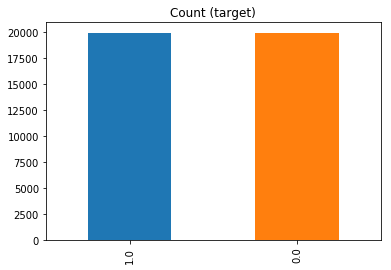

In [24]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
val_df = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
val_df.is_attributed.value_counts().plot(kind='bar', title='Count (target)');

In [25]:
print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

train size:  60000
valid size:  39904
test size :  1000


## Create Feature

In [26]:
train_df.head(2)

,app,channel,click_id,device,ip,is_attributed,os,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeHour,click_timeMinute,click_timeSecond,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed,qty,ip_app_count,ip_app_os_count
0,12,497,NaN,1,87540,0.0,13,2017,11,45,7,1,311,9,30,38,False,False,False,False,False,False,1510047038,1,3,2
1,25,259,NaN,1,105560,0.0,17,2017,11,45,7,1,311,13,40,27,False,False,False,False,False,False,1510062027,1,3,1


In [27]:
train_df.columns

Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os',
       'click_timeYear', 'click_timeMonth', 'click_timeWeek', 'click_timeDay',
       'click_timeDayofweek', 'click_timeDayofyear', 'click_timeHour',
       'click_timeMinute', 'click_timeSecond', 'click_timeIs_month_end',
       'click_timeIs_month_start', 'click_timeIs_quarter_end',
       'click_timeIs_quarter_start', 'click_timeIs_year_end',
       'click_timeIs_year_start', 'click_timeElapsed', 'qty', 'ip_app_count',
       'ip_app_os_count'],
      dtype='object')

In [28]:
cat_vars = ['app', 'channel', 'device', 'ip', 'os',
       'click_timeYear', 'click_timeMonth', 'click_timeWeek', 'click_timeDay',
       'click_timeDayofweek', 'click_timeDayofyear', 'click_timeHour',
       'click_timeMinute', 'click_timeSecond', 'click_timeIs_month_end',
       'click_timeIs_month_start', 'click_timeIs_quarter_end',
       'click_timeIs_quarter_start', 'click_timeIs_year_end',
       'click_timeIs_year_start']

contin_vars = ['qty', 'ip_app_count',
       'ip_app_os_count']

n = len(train_df); n

60000

In [29]:
dep = 'is_attributed'
joined = train_df[cat_vars+contin_vars+[dep]].copy()

In [30]:
test_df.columns

Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os',
       'click_timeYear', 'click_timeMonth', 'click_timeWeek', 'click_timeDay',
       'click_timeDayofweek', 'click_timeDayofyear', 'click_timeHour',
       'click_timeMinute', 'click_timeSecond', 'click_timeIs_month_end',
       'click_timeIs_month_start', 'click_timeIs_quarter_end',
       'click_timeIs_quarter_start', 'click_timeIs_year_end',
       'click_timeIs_year_start', 'click_timeElapsed', 'qty', 'ip_app_count',
       'ip_app_os_count'],
      dtype='object')

In [31]:
test_df[dep] = 0
joined_test = test_df[cat_vars+contin_vars+[dep, 'click_id', 'click_timeElapsed']].copy()

In [32]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [33]:
apply_cats(joined_test, joined)

C:\Users\NokChan\.kaggle\competitions\talkingdata-adtracking-fraud-detection\fastai\structured.py:200: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [34]:
(joined=='NaN').sum()

app                           0
channel                       0
device                        0
ip                            0
os                            0
click_timeYear                0
click_timeMonth               0
click_timeWeek                0
click_timeDay                 0
click_timeDayofweek           0
click_timeDayofyear           0
click_timeHour                0
click_timeMinute              0
click_timeSecond              0
click_timeIs_month_end        0
click_timeIs_month_start      0
click_timeIs_quarter_end      0
click_timeIs_quarter_start    0
click_timeIs_year_end         0
click_timeIs_year_start       0
qty                           0
ip_app_count                  0
ip_app_os_count               0
is_attributed                 0
dtype: int64

In [35]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [36]:
df, y, nas, mapper = proc_df(joined, 'is_attributed', do_scale=True)
yl = np.log(y)

C:\Users\NokChan\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [37]:
joined_test = joined_test.set_index("click_timeElapsed")

In [38]:
joined_test.head()

,app,channel,device,ip,os,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeHour,click_timeMinute,click_timeSecond,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,qty,ip_app_count,ip_app_os_count,is_attributed,click_id
click_timeElapsed,,,,,,,,,,,,,,,,,,,,,,,,,
1510286400,9,107,1,NaN,3,2017,11,45,NaN,NaN,NaN,4,0,0,False,False,False,False,False,False,1.0,1.0,1.0,0,0.0
1510286400,9,466,1,119901.0,3,2017,11,45,NaN,NaN,NaN,4,0,0,False,False,False,False,False,False,2.0,4.0,1.0,0,1.0
1510286400,21,128,1,72287.0,19,2017,11,45,NaN,NaN,NaN,4,0,0,False,False,False,False,False,False,1.0,1.0,1.0,0,2.0
1510286400,15,111,1,78477.0,13,2017,11,45,NaN,NaN,NaN,4,0,0,False,False,False,False,False,False,1.0,1.0,1.0,0,3.0
1510286400,12,328,1,NaN,13,2017,11,45,NaN,NaN,NaN,4,0,0,False,False,False,False,False,False,1.0,1.0,1.0,0,4.0


In [39]:
df_test, _, nas, mapper = proc_df(joined_test, 'is_attributed', do_scale=True, skip_flds=['click_id'],
                                  mapper=mapper, na_dict=nas)

## DL

In [40]:
import pandas_summary

In [41]:
pandas_summary.DataFrameSummary(joined_test).summary()

,app,channel,device,ip,os,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeHour,click_timeMinute,click_timeSecond,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,qty,ip_app_count,ip_app_os_count,is_attributed,click_id
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1000,1000,1000,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.858,2.27,1.213,0,499.5
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.41698,5.98121,0.82481,0,288.819
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,249.75
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,499.5
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,0,749.25
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,104,18,0,999
counts,1000,1000,999,694,999,1000,1000,1000,0,0,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
uniques,33,85,4,497,52,1,1,1,0,0,0,1,1,2,1,1,1,1,1,1,8,26,8,1,1000


In [42]:
joined.head()

,app,channel,device,ip,os,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeHour,click_timeMinute,click_timeSecond,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,qty,ip_app_count,ip_app_os_count,is_attributed
0,12,497,1,87540,13,2017,11,45,7,1,311,9,30,38,False,False,False,False,False,False,1.0,3.0,2.0,0.0
1,25,259,1,105560,17,2017,11,45,7,1,311,13,40,27,False,False,False,False,False,False,1.0,3.0,1.0,0.0
2,12,212,1,101424,19,2017,11,45,7,1,311,18,5,24,False,False,False,False,False,False,1.0,1.0,1.0,0.0
3,13,477,1,94584,13,2017,11,45,7,1,311,4,58,8,False,False,False,False,False,False,1.0,1.0,1.0,0.0
4,12,178,1,68413,1,2017,11,45,9,3,313,9,0,9,False,False,False,False,False,False,1.0,2.0,1.0,0.0


In [43]:
from fastai.column_data import *

In [44]:
path

WindowsPath('.')

In [45]:
np.arange(len(joined))[int(len(joined)*0.8) :]

array([48000, 48001, 48002, ..., 59997, 59998, 59999])

In [46]:
import pdb
# pdb.set_trace()
md = ColumnarModelData.from_data_frame(path,-1, joined, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=None,is_reg=False, is_multi=False)

In [47]:
joined_test.dtypes

app                           category
channel                       category
device                        category
ip                            category
os                            category
click_timeYear                category
click_timeMonth               category
click_timeWeek                category
click_timeDay                 category
click_timeDayofweek           category
click_timeDayofyear           category
click_timeHour                category
click_timeMinute              category
click_timeSecond              category
click_timeIs_month_end        category
click_timeIs_month_start      category
click_timeIs_quarter_end      category
click_timeIs_quarter_start    category
click_timeIs_year_end         category
click_timeIs_year_start       category
qty                            float32
ip_app_count                   float32
ip_app_os_count                float32
is_attributed                    int64
click_id                       float64
dtype: object

In [48]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [49]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [50]:
torch.cuda.is_available()

True

In [51]:
a = torch.Tensor(10)

In [52]:
torch.cuda.current_device()

0

In [57]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=1)
lr = 1e-3

C:\Users\NokChan\.kaggle\competitions\talkingdata-adtracking-fraud-detection\fastai\column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
C:\Users\NokChan\.kaggle\competitions\talkingdata-adtracking-fraud-detection\fastai\column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


In [62]:
tmp = iter(md.trn_dl)

In [64]:
xs = next(tmp)

In [65]:
xs

[tensor([[ 3.0000e+00,  2.8000e+02,  1.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.2000e+01,  3.2800e+02,  1.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.0000e+00,  4.4200e+02,  1.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 1.2000e+01,  3.2800e+02,  1.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.1000e+01,  2.1900e+02,  1.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.1000e+01,  4.6900e+02,  1.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]], device='cuda:0'),
 tensor([[   1.,    1.,    1.,    0.],
         [   1.,    1.,    1.,    0.],
         [   1.,    1.,    1.,    0.],
         [   1.,    2.,    1.,    0.],
         [   1.,   11.,    1.,    0.],
         [   1.,    2.,    1.,    0.],
         [   1.,    1.,    1.,    0.],
         [   1.,    2.,    1.,    0.],
         [   1.,    1.,  

In [57]:
m.fit (1e-3, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/469 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (4) : unspecified launch failure at C:/Users/Administrator/Downloads/new-builder/win-wheel/pytorch/aten/src/THC/THCTensorCopy.cu:204

In [56]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/469 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (4) : unspecified launch failure at C:/Users/Administrator/Downloads/new-builder/win-wheel/pytorch/aten/src/THC/THCTensorCopy.cu:204

In [ ]:
m.sched.plot(100)